In [65]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
import pandas as pd

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


In [350]:
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

def alphabeta_rmsd(phi,psi,phi_ref,psi_ref):
 alphabetarmsd=np.sum(0.5*(1+np.cos(psi-psi_ref)),axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)),axis=1)
 return alphabetarmsd 

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 SE_H=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])): 
     data=dsspH[:,i].astype(float) 
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5] 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 SE_E=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E


def calc_phipsi(trj):
 indices_phi, phis = md.compute_phi(trj)
 indices_psi, psis = md.compute_psi(trj)
 phi_label=[]
 for i_phi in range(0, indices_phi.shape[0]):
      resindex=trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
      phi_label.append(resindex)
 phi_label=np.array(phi_label)
 #print(phi_label)
 psi_label=[]
 for i_psi in range(0, indices_psi.shape[0]):
      resindex=trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
      psi_label.append(resindex)
 psi_label=np.array(psi_label)
 #print(psi_label)
 phipsi=[]
 for i in range(0,len(phi_label)-1):
  current_phipsi=np.column_stack((phis[:,i+1],psis[:,i]))
  phipsi.append(current_phipsi)
 phipsi_array=np.array(phipsi)
 return(phipsi_array,psi_label,phi_label)


def get_blockerror_pyblock(Data):
  average=np.average(Data)
  #print(average,Data,len(Data))  
  if (average!=0) and (average!=1):
   reblock_data = pyblock.blocking.reblock(Data)
   opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
   be=reblock_data[opt][4]
  else:
   be=0
  return average,float(be)

def get_blockerror_pyblock_max(Data):
  average=np.average(Data)
  if (average!=0) and (average!=1):
   reblock_data = pyblock.blocking.reblock(Data)
   be_max=0
   for i in range(0,len(reblock_data)): 
     be=reblock_data[i][4]
     if(be > be_max):
       be_max=be
  else:
   be=0
  return average,float(be)

def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

In [37]:
workdir='/Users/paulrobustelli/Asyn_LigandBinding'
outdir='/Users/paulrobustelli/Desktop/Trajectories/Asyn_DESRES/DESRES-Trajectory_biorxiv2021-asyn121to139_Lig41_5475823-no-water-glue/biorxiv2021-5475823-no-water-glue/'
trajdir='/Users/paulrobustelli/Desktop/Trajectories/Asyn_DESRES/DESRES-Trajectory_biorxiv2021-asyn121to139_Lig41_5475823-no-water-glue/biorxiv2021-5475823-no-water-glue/'
pdb='/Users/paulrobustelli/Desktop/Trajectories/Asyn_DESRES/DESRES-Trajectory_biorxiv2021-asyn121to139_Lig41_5475823-no-water-glue/biorxiv2021-5475823-no-water-glue/asyn_ligand41_nowater.pdb'
trajectory='/Users/paulrobustelli/Desktop/Trajectories/Asyn_DESRES/DESRES-Trajectory_biorxiv2021-asyn121to139_Lig41_5475823-no-water-glue/biorxiv2021-5475823-no-water-glue/asyn121to140_fasudil.dcd'

In [38]:
trajdir='/Users/paulrobustelli/Desktop/Trajectories/Asyn_DESRES/DESRES-Trajectory_biorxiv2021-asyn121to139_Lig41_5475823-no-water-glue/biorxiv2021-5475823-no-water-glue'
trj = md.load(trajectory, top=pdb,stride=10)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [39]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues=20
residue_offset=121
residue_number = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)

** SYSTEM INFO **

Number of atoms: 339

Number of residues: 28

Number of protein residues: 20

Number of frames: 111089

Starting frame: 0

Last frame: 111089

sequence:  [ASP121, ASN122, GLU123, ALA124, TYR125, GLU126, MET127, PRO128, SER129, GLU130, GLU131, GLY132, TYR133, GLN134, ASP135, TYR136, GLU137, PRO138, GLU139, ALA140, ASP121, *0, NA1, NA2, NA3, NA4, NA5, NA6, NA7]

residue names:  ['ASP', 'ASN', 'GLU', 'ALA', 'TYR', 'GLU', 'MET', 'PRO', 'SER', 'GLU', 'GLU', 'GLY', 'TYR', 'GLN', 'ASP', 'TYR', 'GLU', 'PRO', 'GLU', 'ALA', 'ASP', '*', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

Residue Number Range: range(121, 141)


<ipython-input-350-13d6eb8afea7>:24: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


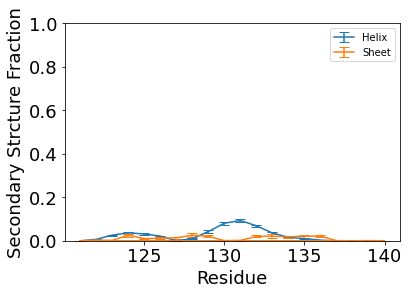

In [390]:
#Protein Only Properties
prot_traj = md.load(trajectory, top=pdb,stride=10)
prot=prot_traj.topology.select("protein")
prot_traj.restrict_atoms(prot)
prot_traj.center_coordinates()
frames=prot_traj.n_frames
time=np.linspace(0,200,prot_traj.n_frames)


dssp=md.compute_dssp(prot_traj, simplified=True)
H1_H,H1_E=dssp_convert(dssp)
prot_res=[]
for res in prot_traj.topology.residues: prot_res.append(res.resSeq)
prot_residues=len(set(prot_res))
residue_offset=0
prot_renum=np.asarray(prot_res)+residue_offset

plt.errorbar(prot_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='Helix')
plt.errorbar(prot_renum,H1_E[:,0],yerr=H1_E[:,1], capsize=5,label='Sheet')

plt.ylim(0,1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.err.dat',np.column_stack((prot_renum,H1_H[:,0],H1_H[:,1])))
np.savetxt(outdir+'Eprop.err.dat',np.column_stack((prot_renum,H1_E[:,0],H1_E[:,1])))

In [71]:
dsspH=np.copy(dssp)
dsspH[dsspH=='H']=1                                                                                      
dsspH[dsspH=='E']=0                                                                                      
dsspH[dsspH=='C']=0                                                                                      
dsspH[dsspH=='NA']=0 
dsspH=dsspH.astype(int)
TotalH=np.sum(dsspH,axis=1) 
prot_res=20
print("Averagr Helical Residues/Frame:%6.3lf"%(np.average(TotalH)),"+_%6.3lf"%((block(TotalH)**.5)))
print("Averagr Fraction Helix:%6.3lf"%(np.average(TotalH)/prot_res),"+_%6.3lf"%((block(TotalH)**.5)/prot_res))

dsspE=np.copy(dssp)
dsspE[dsspE=='H']=0                                                                                      
dsspE[dsspE=='E']=1                                                                                      
dsspE[dsspE=='C']=0                                                                                      
dsspE[dsspE=='NA']=0 
dsspE=dsspE.astype(int)
TotalE=np.sum(dsspE,axis=1) 
print("Average Sheet Residues/Frame:%6.3lf"%(np.average(TotalE)),"+_%6.3lf"%((block(TotalE)**.5)))
print("Average Fraction Sheet:%6.3lf"%(np.average(TotalE)/prot_res),"+_%6.3lf"%((block(TotalE)**.5)/prot_res))

Averagr Helical Residues/Frame: 0.484 +_ 0.028
Averagr Fraction Helix: 0.024 +_ 0.001
Average Sheet Residues/Frame: 0.221 +_ 0.060
Average Fraction Sheet: 0.011 +_ 0.003


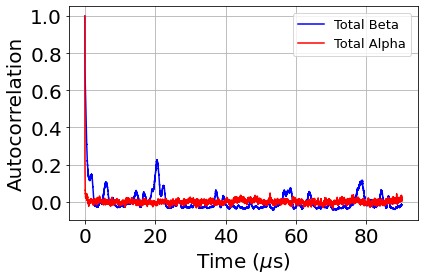

In [385]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

lags=range(50000)
TotalBeta_autocor=autocorr1(TotalE,lags)
TotalAlpha_autocor=autocorr1(TotalH,lags)

plt.plot(time[lags],TotalBeta_autocor,color='b',label='Total Beta')
plt.plot(time[lags],TotalAlpha_autocor,color='r',label='Total Alpha')
plt.legend()
plt.yticks(fontsize=20) 
plt.xticks(fontsize=20) 
plt.xlabel('Time ($\mu$s)',fontsize=20)
plt.ylabel('Autocorrelation',fontsize=20)
plt.legend(loc='upper right',fontsize=13)
plt.grid(True)
#plt.ylim(2.0,10.0)
#plt.xlim(-0.05,3.0)
#plt.xticks([0,0.5,1.0,1.5,2.0,2.5,3.0])
#plt.show()
plt.tight_layout()

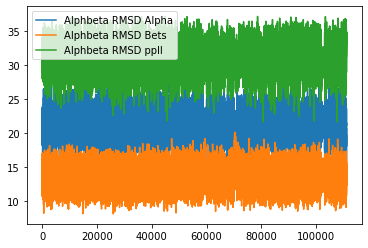

In [525]:
#Compute Phi and Psi
#phipsi_array,psi_labels,phi_labels=calc_phipsi(trj)
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
np.savetxt(outdir+"/phis.dat",phis,fmt="%.3f")
np.savetxt(outdir+"/psis.dat",psis,fmt="%.3f")

Phi_all=phis
Psi_all=psis
alphabeta_alpharight=alphabeta_rmsd(Phi_all,Psi_all,-1.05,-0.79)
alphabeta_betasheet=alphabeta_rmsd(Phi_all,Psi_all,2.36,-2.36)
alphabeta_ppII=alphabeta_rmsd(Phi_all,Psi_all,-1.31,2.71)

plt.plot(alphabeta_alpharight,label='Alphbeta RMSD Alpha')
plt.plot(alphabeta_betasheet,label='Alphbeta RMSD Bets')
plt.plot(alphabeta_ppII,label='Alphbeta RMSD ppII')
plt.legend()

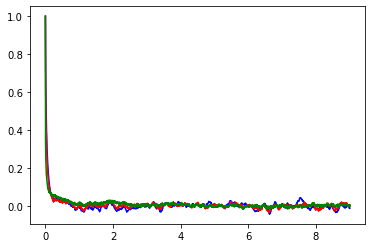

In [526]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

lags=range(5000)
ppII_autocor=autocorr1(alphabeta_ppII,lags)
a_autocor=autocorr1(alphabeta_alpharight,lags)
b_autocor=autocorr1(alphabeta_betasheet,lags)

plt.plot(time[lags],ppII_autocor,color='b')
plt.plot(time[lags],a_autocor,color='r')
plt.plot(time[lags],b_autocor,color='g')


CA Radius of Gyration All: 1.200 +_ 0.007
CA Radius of Gyration Pyblock Max: 1.200 +_ 0.006


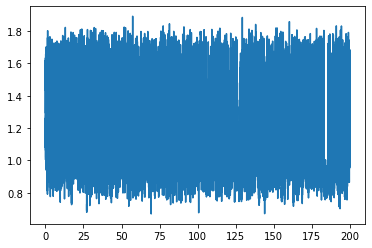

In [527]:
rg=calc_Rg(prot_traj)
print("CA Radius of Gyration All:%6.3lf"%np.average(rg),"+_%6.3lf"%block(rg)**.5)

rg_ave,rg_max_error=get_blockerror_pyblock_max(rg)
print("CA Radius of Gyration Pyblock Max:%6.3lf"%rg_ave,"+_%6.3lf"%rg_max_error)
lags=range(5000)
rg_autocor=autocorr1(rg,lags)
plt.plot(time,rg)

Ca RMSD Pyblock Max: 0.612 +_ 0.004


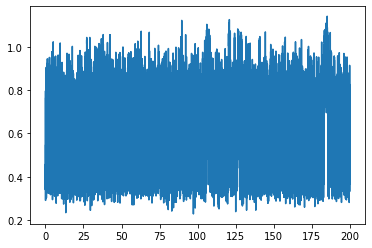

In [528]:
sel=prot_traj.topology.select("name CA")
rmsd = md.rmsd(prot_traj,prot_traj,frame=0,atom_indices=sel)
rmsd_ave,rmsd_max_error=get_blockerror_pyblock_max(rmsd)
print("Ca RMSD Pyblock Max:%6.3lf"%rmsd_ave,"+_%6.3lf"%rmsd_max_error)
lags=range(5000)
rmsd_autocor=autocorr1(rmsd,lags)
plt.plot(time[1:-1],rmsd[1:-1])

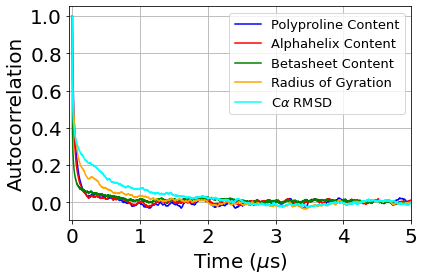

In [529]:
plt.plot(time[lags],ppII_autocor,color='b',label='Polyproline Content')
plt.plot(time[lags],a_autocor,color='r',label='Alphahelix Content')
plt.plot(time[lags],b_autocor,color='g',label='Betasheet Content')
plt.plot(time[lags],rg_autocor,color='orange',label='Radius of Gyration')
plt.plot(time[lags],rmsd_autocor,color='cyan',label=r'C$\alpha$ RMSD')

plt.legend()

plt.yticks(fontsize=20) 
plt.xticks(fontsize=20) 
plt.xlabel('Time ($\mu$s)',fontsize=20)
plt.ylabel('Autocorrelation',fontsize=20)
plt.legend(loc='upper right',fontsize=13)
#plt.legend('')
plt.grid(True)
#plt.ylim(2.0,10.0)
plt.xlim(-0.05,5.0)
plt.xticks([0,1.0,2.0,3.0,4.0,5.0])
#plt.show()
plt.tight_layout()

In [530]:
def monoExp_nob(x, m, t):
    return m * np.exp(-t * x)

def monoExp(x,t):
    return np.exp(-t * x)

def calc_expdecay(time,acf):
 xs=time
 ys=acf
 #plt.plot(xs, ys, '.')
 #plt.title("Original Data")
 p0 = (1, 1) # start with values near those we expect
 params, cv = scipy.optimize.curve_fit(monoExp_nob, xs, ys, p0)
 m, t = params
 tau=(1/t)
 #tauSec = (1 / t) 
 acffit=monoExp_nob(xs, m, t)
 squaredDiffs = np.square(ys - monoExp_nob(xs, m, t))
 squaredDiffsFromMean = np.square(ys - np.mean(ys))
 rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
 print(f"R² = {rSquared}")
 # plot the results
 #plt.plot(xs, ys, '.', label="data",color='black')
 #plt.plot(xs, monoExp_nob(xs, m, t), '--', label="fitted")
 #plt.title("Fitted Exponential Curve")
 # inspect the parameters
 print("M:",m,"t:",t,"Tau:",tau)
 return(acf,acffit,[m,t,tau])

def calc_expdecay_nom(time,acf):
 xs=time
 ys=acf
 #plt.plot(xs, ys, '.')
 #plt.title("Original Data")
 p0 = (1) # start with values near those we expect
 params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
 t = params
 tau=(1/t)
 #tauSec = (1 / t) 
 acffit=monoExp(xs,t)
 squaredDiffs = np.square(ys - monoExp(xs,t))
 squaredDiffsFromMean = np.square(ys - np.mean(ys))
 rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
 print(f"R² = {rSquared}")
 # plot the results
 #plt.plot(xs, ys, '.', label="data",color='black')
 #plt.plot(xs, monoExp(xs,t), '--', label="fitted")
 #plt.title("Fitted Exponential Curve")
 # inspect the parameters
 print("t:",t,"Tau:",tau)
 return(acf,acffit,[t,tau])

R² = 0.8904977142416539
M: 0.7940788018636062 t: 18.030562170135696 Tau: 0.05546138775729998
R² = 0.8941308062711439
M: 0.666537656560747 t: 18.756167283623476 Tau: 0.053315796605905054
R² = 0.59859100667972
M: 0.20583232498556267 t: 5.215448323725845 Tau: 0.19173807080991528
R² = 0.8599225759689962
M: 0.46426971251711774 t: 4.543025026876121 Tau: 0.22011765158327137
R² = 0.9034510886160503
M: 0.36733844217995865 t: 1.8389936520262284 Tau: 0.543775667141747


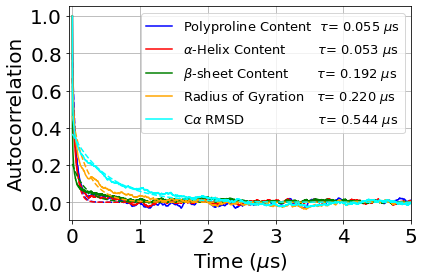

In [536]:
#acf,acffit,params=calc_expdecay_nom(time[lags],ppII_autocor)
acf,acffit,params=calc_expdecay(time[lags],ppII_autocor)
tau=params[2]
plt.plot(time[lags],ppII_autocor,color='b',label=r'Polyproline Content  $\tau$=%6.3lf $\mu$s'%tau)
plt.plot(time[lags],acffit,color='b',linestyle='dashed')

acf,acffit,params=calc_expdecay(time[lags],a_autocor)
tau=params[2]
plt.plot(time[lags],a_autocor,color='r',label=r'$\alpha$-Helix Content        $\tau$=%6.3lf $\mu$s'%tau)
plt.plot(time[lags],acffit,color='r',linestyle='dashed') 
 
acf,acffit,params=calc_expdecay(time[lags],b_autocor)
tau=params[2]
plt.plot(time[lags],b_autocor,color='g',label=r'$\beta$-sheet Content       $\tau$=%6.3lf $\mu$s'%tau)
plt.plot(time[lags],acffit,color='g',linestyle='dashed')

acf,acffit,params=calc_expdecay(time[lags],rg_autocor)
tau=params[2]
plt.plot(time[lags],rg_autocor,color='orange',label=r'Radius of Gyration   $\tau$=%6.3lf $\mu$s'%tau)
plt.plot(time[lags],acffit,color='orange',linestyle='dashed')

acf,acffit,params=calc_expdecay(time[lags],rmsd_autocor)
tau=params[2]
plt.plot(time[lags],rmsd_autocor,color='cyan',label=r'C$\alpha$ RMSD                  $\tau$=%6.3lf $\mu$s'%tau)
plt.plot(time[lags],acffit,color='cyan',linestyle='dashed')

plt.legend()

plt.yticks(fontsize=20) 
plt.xticks(fontsize=20) 
plt.xlabel('Time ($\mu$s)',fontsize=20)
plt.ylabel('Autocorrelation',fontsize=20)
plt.legend(loc='upper right',fontsize=13)
#plt.legend('')
plt.grid(True)
#plt.ylim(2.0,10.0)
plt.xlim(-0.05,5.0)
plt.xticks([0,1.0,2.0,3.0,4.0,5.0])
#plt.show()
plt.tight_layout()